---

## HW01 AutoEncoder (PyTorch)

다음을 확인하는 리포트를 Colab 노트북을 이용해 작성한다.

1. 정규분포를 통한 파라미터 초기화를 진행한 `Linear` layer를 Xavier 초기화, He 초기화 기법을 통해 초기화를 진행한 뒤, 결과에 대해 분석한다.

2. Autoencoder의 encoder를 거쳐 나온 representation $z$를 groud truth(GT) label별로 다른색을 주어 $z$의 분포를 가시화한다.

3. $z$의 분포를 보고 encoder가 label별로 discriminative한 representation을 만들어내는지 확인한다.

4. 만일 discriminative하지 않다면, autoencoder가 discriminative한 representation $z$를 학습하도록 $z$의 차원을 바꿔가면서 실험해본다.

5. $z$ 공간의 임의의 위치를 sampling한 후, 학습된 decoder의 입력으로 주는 방식으로 generative model을 구축한다. <br/>
의미있게 만들어진 이미지는 어떤 특징을 갖고 있는지 논의한다.

6. Autoencoder의 `LInear` layer를 `Conv` layer로 수정하여 실험을 진행한다.

---

# 오토인코더 (Pytorch)
Pytorch에서 제공하는 고수준 API를 이용해, 오토인코더(autoencoder)를 구현한다.

참고문헌
* [Pytorch tutorial](https://tutorials.pytorch.kr/)
* [Dive into Deep learning](https://d2l.ai/)


주의사항
* Colab에서 코드에 이상이 없음에도 불구하고 결과가 제대로 나오지 않을 경우, '런타임 다시 시작...'을 해보도록 한다.'


## Deep Neural Network 기초
다음 비디오를 보고 심층신경망(deep neural network) 기반 딥러닝 기법은 이해하도록 한다.
* [신경망이란 무엇인가? | 1장.딥러닝에 관하여 (3Blue1Brown)](https://youtu.be/aircAruvnKk)
* [경사 하강, 신경 네트워크가 학습하는 방법 | 심층 학습, 2장 (3Blue1Brown)](https://youtu.be/IHZwWFHWa-w)
* [What is backpropagation really doing? | Deep learning, chapter 3 (3Blue1Brown)](https://youtu.be/Ilg3gGewQ5U)
* [Backpropagation calculus | Deep learning, chapter 4 (3Blue1Brown)](https://youtu.be/tIeHLnjs5U8)

## 필요한 모듈 임포트


In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import torch                                      # 파이토치 임포트
import torch.nn as nn                             # nn 모듈 임포트
import torch.nn.functional as F

import torchvision                                # torchvision 임포트
import torchvision.utils as utils
import torchvision.transforms as transforms       # numpy 이미지에서 tensor 이미지로 변경하기 위한 모듈
import torchvision.datasets as datasets           # pytorch에 내장된 dataset을 불러오기 위한 모듈

from tqdm import tqdm

print("Python:", sys.version)
print("Numpy:", np.__version__)

print("Torch: ", torch.__version__)               # 파이토치 버전을 확인하도록 한다.
print("Torchvision: ", torchvision.__version__)   # 토치비전 버전을 확인하도록 한다.


Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Numpy: 1.22.4
Torch:  1.13.1+cu116
Torchvision:  0.14.1+cu116


## GPU 동작 확인

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cuda:0
True
Tesla T4


## Hyperparameter 설정
* batch size, learning rate, epoch을 설정

In [3]:
batch_size    = 100
learning_rate = 0.001
num_epochs    = 10

## MNIST 데이터셋 띄우기
![MnistExamples.png](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)
* mnist 데이터셋은 숫자(digit) 손글씨 데이터셋이다.
* 60,000개의 트레이닝 데이터와 10,000개의 테스트 데이터로 이루어져 있다.
* LeCun이 자신의 연구에서 활용하고 배포한 데이터셋이 있으나 최근 보편적으로 많이 활용하기 때문에 텐서플로우나 파이토치 등에서 built-in 데이터셋의 형태로 제공해 주기도 한다.  

### MNIST 이미지 데이터
* MNIST 데이터셋은 여러 버젼이 있으나, 여기서는 이를 파이토치에 맞게 정리하여 torchvision.datasets에서 built-in으로 제공하는 데이터셋을 쓰도록 하겠다. ([link](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)) 
  + (PIL image, integer label)로 구성된 데이터를 제공.
  + PIL image는 각 픽셀이 [0, 255] 사이값으로 구성된 H x W x C 크기의 이미지이다.
* 뉴럴넷의 입력으로 넣기 위해 픽셀값이 0 근처에 있는 작은 실수값을 가지도록 다음과 같이 변환한다.
  + ToTensor(): [0, 255] 사이 값을 [0.0, 1.0] 사이값으로 변화시킴과 동시에 C x H x W 형태로 변환시킨다.


In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# download path 정의
download_root = './MNIST_DATASET'


# PIL image (H x W x C) -> torch tensor (C x H x W) and 
# [0, 255] -> [0.0, 1.0]
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
])

train_dataset = MNIST(download_root, 
                      transform=mnist_transform, 
                      train=True, 
                      download=True)

test_dataset = MNIST(download_root,
                     transform=mnist_transform, 
                     train=False, 
                     download=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



## 데이터셋 확인
데이터셋을 로딩한 후 **데이터셋 구성**이 어떻게 되어 있는지 **반드시 확인**하는 습관을 가지도록 한다.

torchvision.datasets.MNIST 데이터셋의 각 데이터는 (이미지, 레이블)로 구성된 튜플이다. 

다음은 MNIST 데이터셋에 있는 이미지와 레이블에 대한 각종 정보를 확인하는 코드이다. 

해당 코드를 통해 다음 사항을 확인할 수 있다.
* train_dataset의 길이는 60,000이다. 
* test_dataset의 길이는 10,000이다.

### MNIST 이미지 데이터
* 각 이미지는 C X H x W 순서로 구성된 [1, 28, 28] 모양의 텐서로 로딩되었다.
* 각 이미지 픽셀값은 ToTensor() 변환을 통해 [0.0, 1.0] 사이의 값으로 변환되었다.
* 각 이미지 픽셀값은 `torch.float32` 타입이다.
* 각 레이블 값의 타입은 파이썬 `int` 형이다.

### MNIST 라벨 데이터
* 각 레이블 값은 [0, 9] 사이의 파이썬 `int`형이다.

In [5]:
def print_MNIST_dataset_info(dataset):
  print(">>> dataset length: ", len(dataset))
  print(">>> type of each data: ", type(dataset[0]))
  first_img, first_label = dataset[0]
  print(">>> image shape: ", first_img.shape)
  print(">>> image dtype: ", first_img.dtype)
  print(">>> image pixel min-value: ", first_img.min())
  print(">>> image pixel max-value: ", first_img.max())
  print(">>> label data type: ", type(first_label))

print("train dataset")
print_MNIST_dataset_info(train_dataset)

print("test dataset")
print_MNIST_dataset_info(test_dataset)

train dataset
>>> dataset length:  60000
>>> type of each data:  <class 'tuple'>
>>> image shape:  torch.Size([1, 28, 28])
>>> image dtype:  torch.float32
>>> image pixel min-value:  tensor(0.)
>>> image pixel max-value:  tensor(1.)
>>> label data type:  <class 'int'>
test dataset
>>> dataset length:  10000
>>> type of each data:  <class 'tuple'>
>>> image shape:  torch.Size([1, 28, 28])
>>> image dtype:  torch.float32
>>> image pixel min-value:  tensor(0.)
>>> image pixel max-value:  tensor(1.)
>>> label data type:  <class 'int'>


## MNIST DataLoader 정의

파이토치 데이터로더는 데이터셋을 배치단위로 묶어 순회(iteration)할 수 있도록 한다. 

아래 코드는 데이터셋에 대한 데이터로더를 만들고, 각 배치가 어떤 텐서 형태로 구성되어 있는지 확인하는 코드이다. 
* 데이터로더에서는 이미지들이 배치단위로 묶였기 때문에, [B, C, H, W] 모양의 텐서가 되었음을 확인하자.
* 데이터로더에서는 레이블들이 배치단위로 묶였기 때문에, [B] 모양의 텐서가 되었음을 확인하자.

train_dataset과 test_dataset은 동일 형태이므로, train_dataset의 데이터로더에 대해서만 확인하였다.



In [6]:
from torch.utils.data import DataLoader

# dataloader 정의
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [7]:
def print_MNIST_data_loader_info(data_loader):
  print(">>> dataset length: ", len(data_loader))
  print(">>> batch_size: ", data_loader.batch_size)
  batch_images, batch_labels = next(iter(train_loader))
  # batch size로 묶은 data 이미지의 형태 확인
  print(">>> batch_images type", type(batch_images))
  print(">>> batch_images shape", batch_images.shape)
  print(">>> batch_images dtype", batch_images.dtype)

print("train dataset")
print_MNIST_data_loader_info(train_loader)

print("test dataset")
print_MNIST_data_loader_info(test_loader)

train dataset
>>> dataset length:  600
>>> batch_size:  100
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([100, 1, 28, 28])
>>> batch_images dtype torch.float32
test dataset
>>> dataset length:  100
>>> batch_size:  100
>>> batch_images type <class 'torch.Tensor'>
>>> batch_images shape torch.Size([100, 1, 28, 28])
>>> batch_images dtype torch.float32


### 첫번째 배치의 첫번째 이미지와 레이블 확인
첫 이미지와 해당 레이블을 찍어서 확인해 보자.

C x H x W 이미지 정보가 보관된 파이토치 텐서를 H x W x C 형태의 PIL 이미지로 변환시키는 편리한 방법은 `to_pil_images` 함수를 사용하는 것이다. 이 예제에서는 [-1.0, 1.0] 값으로 픽셀값이 normalize되어 있으므로, [0.0, 1.0] 값으로 denormalize 시킨 후, 호출하면 [0, 255] 값으로 변환된다.


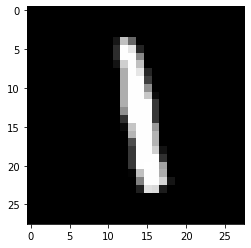

In [8]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# 첫번째 이미지 한장에 대한 확인
batch_images, batch_labels = next(iter(train_loader))

img = batch_images[0]

plt.figure()
plt.imshow(to_pil_image(img), cmap='gray')

## 네트워크 모델 설계
* 인코더 모델: `torch.nn.Sequential` 모듈로 모델로 설계
  + InputLayer로 (28,28) 영상을 받고, Linear 레이어를 여럿 통과시킨 후, 출력으로 n_dim차원 벡터가 나오도록 함.
* 디코더 모델: `torch.nn.Sequential` 모듈로 모델로 설계
  + InputLayer에서 n_dim차원 벡터를 받고, Linear 레이어를 여럿 통과시킨 후, 출력으로 (28,28) 영상이 나오도록 함.
* 오토인코더 모델: 인코더, 디코더를 결합하여 설계


여기서는 n_dim을 우선 2로 설정한다.
* 즉, n_dim=2

In [9]:
n_dim = 2
# n_dim = 5
# n_dim = 10

인코더 모델 정의
* (28, 28) 영상을 입력으로 받도록 입력 레이어 정의
* Flatten으로 입력 텐서를 784-vector로 벡터라이즈
* Fully connected layer로 784 > 256 > 128 > 32 > n_dim 로 차원 축소

In [10]:
enc = nn.Sequential(
  nn.Flatten(),    # 784 = 1 x 28 x 28
  nn.Linear(784, 256),
  nn.ReLU(),
  nn.Linear(256, 128),
  nn.ReLU(),
  nn.Linear(128, 32), 
  nn.ReLU(),
  nn.Linear(32, n_dim)
)

enc = enc.to(device)

print(enc)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=32, bias=True)
  (6): ReLU()
  (7): Linear(in_features=32, out_features=2, bias=True)
)


디코더 모델 정의
* Fully connected layey로 n_dim > 32 > 128 > 256 > 784로 차원 확대
* 784-vector를 Reshape을 통해 (28, 28)의 텐서로 변환

In [11]:
dec = nn.Sequential(
    nn.Linear(n_dim, 32),
    nn.ReLU(),
    nn.Linear(32, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Unflatten(1, torch.Size([1, 28, 28])),
    nn.Sigmoid(),
)

dec = dec.to(device)

print(dec)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Unflatten(dim=1, unflattened_size=torch.Size([1, 28, 28]))
  (6): Sigmoid()
)


AutoEncoder 모델 정의
* (28, 28) 영상을 입력으로 받도록 입력 레이어 정의
* 입력 레이어 > 인코더 > 디코더로 구성

In [12]:
ae = nn.Sequential(
    enc,
    dec,
)

ae = ae.to(device)

print(ae)

Sequential(
  (0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=2, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Unflatten(dim=1, unflattened_size=torch.Size([1, 28, 28]))
    (6): Sigmoid()
  )
)


## 파라미터 초기화

## TODO

1. encoder, decoder 부분을 수정하여 `Xavier` 또는 `He Initialization`을 적용하여 파라미터를 초기화한 후 학습을 진행해본다. [Xavier, He initialization 설명](https://reniew.github.io/13/)
  * 힌트: `nn.init()`모듈을 살펴본다.

2. 결과에 대한 분석을 작성한다.

# 결과 분석
파라미터 초기화를 하지 않았을 때보다 Xavier 또는 He Initialization을 적용하여 파라미터를 초기화 한 후 학습을 했을 때 학습이 더 빠르고 loss도 더 작은 것을 확인할 수 있었다.

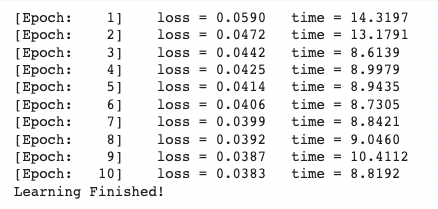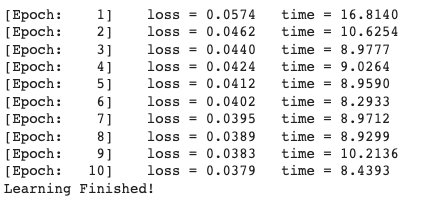

순서대로 Xavier 방법으로 초기화한 모델과 He Initialization으로 초기화한 모델이다. 

두 방법 모두 기존의 초기화 방법보다 정확도가 향상되었다는 것을 알 수 있었다.

허나 현재 encoder와 decoder에서 활성화 함수로 ReLU 함수를 사용하기 때문에 He Initialization으로 초기화를 진행하는 것이 적합하다.

Xavier 초기화 방법을 ReLU 함수에서 사용 시 출력 값이 0으로 수렴하게 되는 현상이 있기 때문이다.

# Xavier 초기화를 사용하였을 때


In [13]:
## TODO
# 정규분포를 따르는 weight 초기화
def init_weights(m):
  if type(m) == nn.Linear:
    # Xavier 초기화 적용
    # nn.init.xavier_uniform_(m.weight)
    # nn.init.zeros_(m.bias)    #Bias 초기화

    # He Initialization 적용
    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    nn.init.zeros_(m.bias)

  elif type(m) == nn.Conv2d:
    # Xavier 초기화 적용
    # nn.init.xavier_uniform_(m.weight)
    # nn.init.zeros_(m.bias)

    # He Initialization 적용
    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    nn.init.zeros_(m.bias)
ae.apply(init_weights)

# print(list(ae.parameters()))

Sequential(
  (0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=2, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Unflatten(dim=1, unflattened_size=torch.Size([1, 28, 28]))
    (6): Sigmoid()
  )
)

## 네트워크 모델 구조 확인

딥러닝 모델의 입출력 구조를 다음과 같이 확인한다.  여기서 중요한 사항은 다음을 확인하는 것이다.

1. 레이어의 연결구조,  
2. 레이어별 입출력 텐서의 차원,
3. 학습할 파라메터 개수


In [14]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from torchsummary import summary

summary(ae, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 32]           4,128
              ReLU-7                   [-1, 32]               0
            Linear-8                    [-1, 2]              66
            Linear-9                   [-1, 32]              96
             ReLU-10                   [-1, 32]               0
           Linear-11                  [-1, 256]           8,448
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 784]         201,488
        Unflatten-14            [-1, 1,

## 훈련 전, 네트워크 모델을 함수로서 활용
* AutoEncoder ae를 모델로 구성했기 때문에, 지금부터 함수로서 활용 가능 
  + 단, ae 함수는 batch 단위로 수행됨을 명심할 것.  
    - 단순히, (1, 28, 28) -> ae -> (1, 28, 28)로 동작하지 않고,
    - batch 단위로 (?, 1, 28, 28) -> ae -> (?, 1, 28, 28)로 병렬처리됨.
* 지금은 훈련 전 네트웍이기 때문에 정상적으로 작동하지 않음.

In [16]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)

  X      = torch.unsqueeze(image, 0).to(device) # batch size = 1 
  Y_pred = ae(X) 

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())
  
  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

## Optimizer, loss 함수 설정
학습과정에서 사용할 optimizer, loss 함수를 설정한다.
* [optim module](https://pytorch.org/docs/stable/optim.html) 참고<br/>
optimizier 이론적 학습: [www](https://brunch.co.kr/@chris-song/50)<br/>
optimizer: torch.optim 모듈 내의  함수들을 다음의 예약어로 쓸 수 있다.
  + sgd = SGD
  + rmsprop = RMSprop
  + adagrad = Adagrad
  + adadelta = Adadelta
  + adam = Adam
  + adamax = Adamax
* [nn module](https://pytorch.org/docs/stable/nn.html) 참고 <br/> 
loss:  torch.nn 모듈 내의  함수들을 다음의 예약어로 쓸 수 있다.
  + mse = MSELoss = mean_squared_error
  + mae = L1Loss = mean_absolute_error
  + kld = KLDivLoss = kullback_leibler_divergence
  + crossentropy = CrossEntropyLoss

In [17]:
# optimizer,loss 설정
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

## 딥러닝 모델 학습

pytorch에서는 tensorflow기반 코드와는 달리 fit() 함수를 직접 구현해야한다.

In [18]:
def fit(data_loader, epochs):
  for epoch in range(epochs):
    now = time.time()
    avg_loss = 0
    total_batch = len(data_loader)
    
    for i, (batch_images, batch_labels) in enumerate(data_loader):

      X = batch_images.to(device)  # [-1, 1, 28, 28]

      # forward 단계
      # 1. input data를 모델에 통과시킵니다.
      # 2. loss를 계산합니다.
      Y_prediction = ae(X)
      loss = criterion(Y_prediction, X)

      # bacward 단계
      # 1. backprop 단계를 실행하기 전에 변화도를 0으로 만듭니다.
      # 2. 모델의 매개변수에 대한 손실의 변화도를 계산합니다.
      # 3. step 함수를 호출하면 매개변수가 갱신됩니다.
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      avg_loss += loss / total_batch

    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
          .format(epoch + 1, avg_loss.data, time.time()-now))
      
  print("Learning Finished!")

fit 함수 실행

In [19]:
fit(train_loader, num_epochs)

[Epoch:    1] 	 loss = 0.0579 	 time = 8.8915
[Epoch:    2] 	 loss = 0.0472 	 time = 10.0568
[Epoch:    3] 	 loss = 0.0440 	 time = 19.4340
[Epoch:    4] 	 loss = 0.0423 	 time = 9.1592
[Epoch:    5] 	 loss = 0.0412 	 time = 8.8726
[Epoch:    6] 	 loss = 0.0405 	 time = 9.3372
[Epoch:    7] 	 loss = 0.0398 	 time = 9.3142
[Epoch:    8] 	 loss = 0.0393 	 time = 9.2768
[Epoch:    9] 	 loss = 0.0388 	 time = 8.7569
[Epoch:   10] 	 loss = 0.0385 	 time = 10.7382
Learning Finished!


### 트레이닝셋을 이용해 학습 후 결과 시각화
학습이 끝난 autoencoder에 대해 train_dataset에 대한 결과 시각화

In [20]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)

  X = torch.unsqueeze(image, 0).to(device) # batch size = 1 
  Y_pred = ae(X)

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())

  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

### 테스트셋을 이용해 학습 후 결과 시각화 
학습이 끝난 autoencoder에 대해 test_dataset에 대한 결과 시각화

In [21]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def test_dataset_imshow(idx):
  (image, label) = test_dataset[idx]
  print('GT label:', label)

  X      = torch.unsqueeze(image, 0).to(device) # batch size = 1 
  Y_pred = ae(X)

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())
  
  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(test_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(test_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=9999), Output()), _do…

<function __main__.test_dataset_imshow(idx)>

# 인코더 / 디코더 모델을 각각 따로 함수로서 활용하기
오토인코더 네트웍 전체가 아닌 enc() 부분과 dec() 부분을 각각 수행할 수 있다.
* 특정 예제에 대한 인코딩 결과와 디코딩 결과를 따로 확인한다.


GT label: 8
latent code z:  tensor([[-1.3989,  1.7905]], device='cuda:0', grad_fn=<AddmmBackward0>)


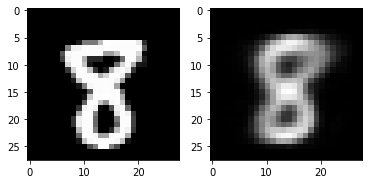

In [22]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

idx = 128

(image, label) = test_dataset[idx]
print('GT label:', label)

### 아래에서 ae()가 사용되지 않고, enc()와 dec()가 사용되었음에 주목
X      = torch.unsqueeze(image, 0).to(device) # batch size = 1 
z      = enc(X)   # enc()만 사용해 입력 영상을 인코딩해 latent code z를 구함 
Y_pred = dec(z)   # dec()만 사용해 latent code z를 디코딩해 출력 영상 Y_pred를 구함

print("latent code z: ", z)

input_img  = to_pil_image(X.squeeze())
output_img = to_pil_image(Y_pred.squeeze())

plt.subplot(121)
plt.imshow(input_img, cmap='gray')

plt.subplot(122)
plt.imshow(output_img, cmap='gray')

인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인

In [23]:
import ipywidgets as widgets

u=widgets.FloatSlider(min=-10.0, max=10.0)
v=widgets.FloatSlider(min=-10.0, max=10.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  
  print(z_test)
  
  z_test = torch.FloatTensor(z_test).to(device)
  img_gen = dec(z_test)

  img_gen = to_pil_image(img_gen.squeeze())

  plt.imshow(img_gen, cmap='gray')
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

## TODO
1. encoder를 거쳐 나온 representation z를 GT label 별로 다른색을 주어 z의 분포를 가시화한다.
2. z의 분포를 보고 encoder가 label 별로 discriminative한 representation을 만들어내는지 여부를 확인한다.
3. 만일 discriminative하지 않다면, autoencoder가 discriminative한 representation z를 학습하도록 z의 차원을 바꿔가면서 실험을 진행한다.
4. 결과에 대한 분석을 작성한다.

## 인코딩 결과 가시화
오토인코더의 encoder가 만들어 내는 representation인 z 값을 가시화 한다. 

# 결과 분석
discriminative한 representation을 나타내기 위해 다양한 방법을 시도하였다.

plot으로 가시화하고, scatter로 가시화하고, t-SNE 기법을 활용하여 가시화하기도 하였지만 label 별로 discriminative 한 결과가 나타나지 않았다.

그래서 n_dim을 2에서 5로 올려보고 10으로도 올려서 학습한 결과 label 별로 discriminative한 결과를 확인할 수 있었다.

[n_dim = 2일 때]

순서대로 plot, tsne이다.


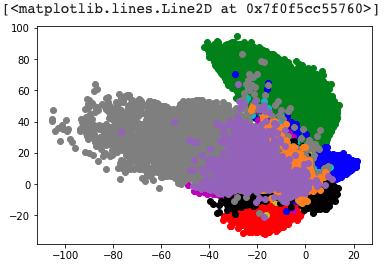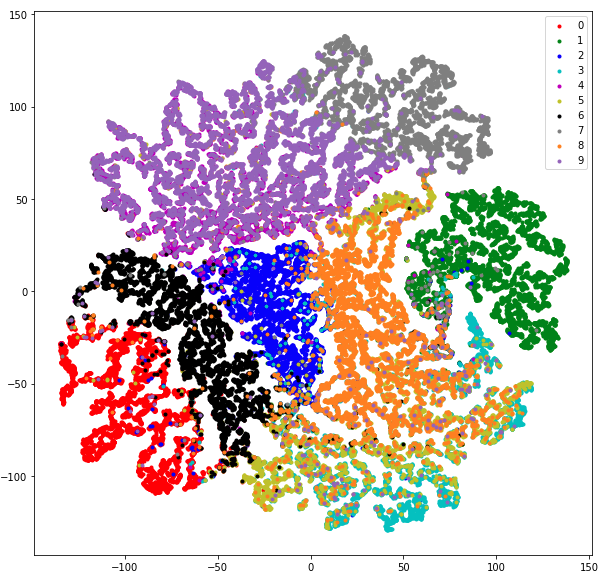

[n_dim = 5일 때]

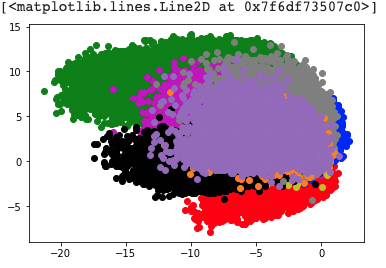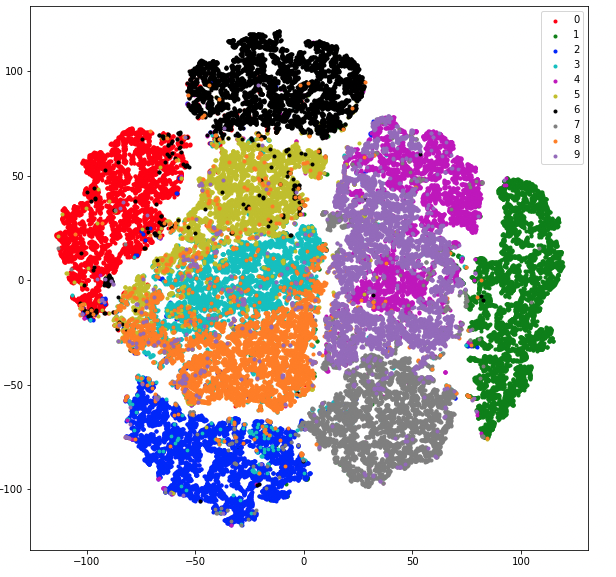

[n_dim = 10일 때]

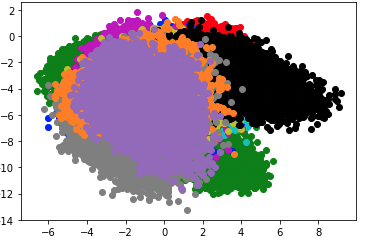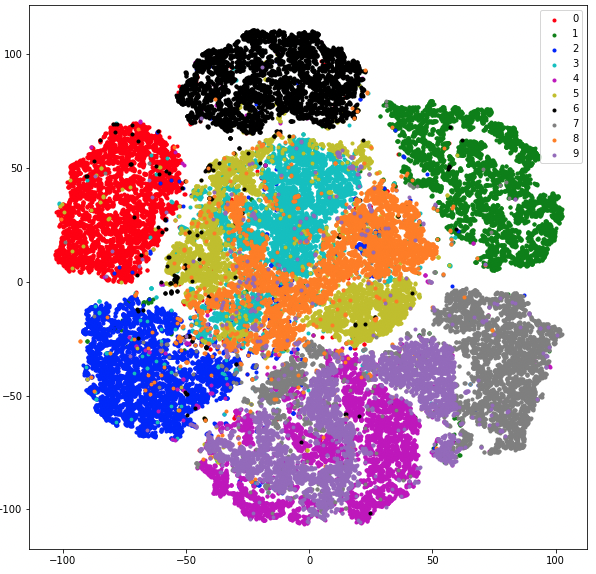

따라서 z의 차원을 적절하게 바꾸는 것이 label 별로 discriminative하게 가시화하는 데에 중요하다는 것을 알 수 있었다.

tensor([[-1.8833,  1.3132],
        [ 1.5060,  0.7005],
        [-0.3823,  3.6023],
        ...,
        [-1.6985,  1.4430],
        [ 1.4171,  2.4639],
        [-4.2124,  1.0919]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([5923, 2])
torch.Size([6742, 2])
torch.Size([5958, 2])
torch.Size([6131, 2])
torch.Size([5842, 2])
torch.Size([5421, 2])
torch.Size([5918, 2])
torch.Size([6265, 2])
torch.Size([5851, 2])
torch.Size([5949, 2])


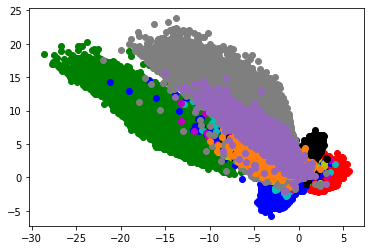

In [24]:
# MNIST 데이터의 latent code 가시화
import matplotlib.pyplot as plt

# 테스트셋의 whole batch에 대한 결과 확인을 위한 dataloader 정의
whole_test_loader = DataLoader(dataset=test_dataset,
                               batch_size=len(test_dataset),
                               shuffle=False)

whole_test_images, whole_test_labels = next(iter(whole_test_loader))

whole_train_loader = DataLoader(dataset=train_dataset,
                               batch_size=len(train_dataset),
                               shuffle=False)
whole_train_images, whole_train_labels = next(iter(whole_train_loader))

whole_test_images = whole_test_images.to(device)
whole_test_labels = whole_test_labels.to(device)
whole_train_images = whole_train_images.to(device)
whole_train_labesl = whole_train_images.to(device)


## TODO: whole_train_images에 대한 인코딩 함수 enc()를 이용해 latent codes z 구하기 
z = enc(whole_train_images)
print(z)

# z 배열을 레이블 조건을 이용해 슬라이싱
z_0 = z[whole_train_labels==0]
z_1 = z[whole_train_labels==1]
z_2 = z[whole_train_labels==2]
z_3 = z[whole_train_labels==3]
z_4 = z[whole_train_labels==4]
z_5 = z[whole_train_labels==5]
z_6 = z[whole_train_labels==6]
z_7 = z[whole_train_labels==7]
z_8 = z[whole_train_labels==8]
z_9 = z[whole_train_labels==9]

print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_3.shape)
print(z_4.shape)
print(z_5.shape)
print(z_6.shape)
print(z_7.shape)
print(z_8.shape)
print(z_9.shape)

# # TODO: 레이블 별로 다른 색을 이용해 가시화
plt.plot(z_0[:,0].detach().cpu().numpy(), z_0[:,1].detach().cpu().numpy(), 'ro')
plt.plot(z_1[:,0].detach().cpu().numpy(), z_1[:,1].detach().cpu().numpy(), 'go')
plt.plot(z_2[:,0].detach().cpu().numpy(), z_2[:,1].detach().cpu().numpy(), 'bo')
plt.plot(z_3[:,0].detach().cpu().numpy(), z_3[:,1].detach().cpu().numpy(), 'co')
plt.plot(z_4[:,0].detach().cpu().numpy(), z_4[:,1].detach().cpu().numpy(), 'mo')
plt.plot(z_5[:,0].detach().cpu().numpy(), z_5[:,1].detach().cpu().numpy(), 'yo')
plt.plot(z_6[:,0].detach().cpu().numpy(), z_6[:,1].detach().cpu().numpy(), 'ko')
plt.plot(z_7[:,0].detach().cpu().numpy(), z_7[:,1].detach().cpu().numpy(), color='tab:grey', marker='o',linestyle='')
plt.plot(z_8[:,0].detach().cpu().numpy(), z_8[:,1].detach().cpu().numpy(), color='tab:orange', marker='o',linestyle='')
plt.plot(z_9[:,0].detach().cpu().numpy(), z_9[:,1].detach().cpu().numpy(), color='tab:purple', marker='o',linestyle='')



# Scatter 함수와 마커 크기 조절로 좀 더 discriminative 하게 가시화 하기

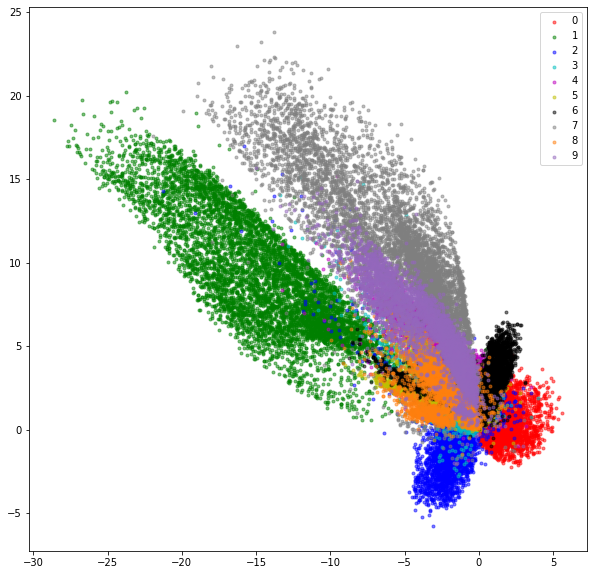

In [25]:
# 레이블 별로 다른 색을 이용해 가시화
plt.figure(figsize=(10, 10))
plt.scatter(z_0[:, 0].detach().cpu().numpy(), z_0[:, 1].detach().cpu().numpy(), marker = '.', c='r', label='0', alpha=0.5)
plt.scatter(z_1[:, 0].detach().cpu().numpy(), z_1[:, 1].detach().cpu().numpy(), marker = '.', c='g', label='1', alpha=0.5)
plt.scatter(z_2[:, 0].detach().cpu().numpy(), z_2[:, 1].detach().cpu().numpy(), marker = '.', c='b', label='2', alpha=0.5)
plt.scatter(z_3[:, 0].detach().cpu().numpy(), z_3[:, 1].detach().cpu().numpy(), marker = '.', c='c', label='3', alpha=0.5)
plt.scatter(z_4[:, 0].detach().cpu().numpy(), z_4[:, 1].detach().cpu().numpy(), marker = '.', c='m', label='4', alpha=0.5)
plt.scatter(z_5[:, 0].detach().cpu().numpy(), z_5[:, 1].detach().cpu().numpy(), marker = '.', c='y', label='5', alpha=0.5)
plt.scatter(z_6[:, 0].detach().cpu().numpy(), z_6[:, 1].detach().cpu().numpy(), marker = '.', c='k', label='6', alpha=0.5)
plt.scatter(z_7[:, 0].detach().cpu().numpy(), z_7[:, 1].detach().cpu().numpy(), marker = '.', c='tab:grey', label='7', alpha=0.5)
plt.scatter(z_8[:, 0].detach().cpu().numpy(), z_8[:, 1].detach().cpu().numpy(), marker = '.', c='tab:orange', label='8', alpha=0.5)
plt.scatter(z_9[:, 0].detach().cpu().numpy(), z_9[:, 1].detach().cpu().numpy(), marker = '.', c='tab:purple', label='9', alpha=0.5)
plt.legend()
plt.show()


# 고차원 데이터를 시각화하기 위한 기법인 t-SNE 활용
"discriminative한 representation z를 학습하도록 z의 차원을 바꿔가면서 실험"에서 힌트를 얻어 검색을 하던 도중, t-SNE라는 기법을 알게 되었다.

t-SNE 기법은 높은 차원의 복잡한 데이터를 2차원에 차원 축소하는 방법으로, 낮은 차원 공간의 시각화에 주로 사용하며 차원 축소할 때는 비슷한 구조끼리 데이터를 정리한 상태이므로 데이터 구조를 이해하는 데 도움을 준다고 한다.


# t-SNE의 특징

*   저차원 공간에서 가까운 점들이 고차원 공간에서도 가까이 위치하도록 보존되므로, 시각화에 적합한 데이터 구조를 생성할 수 있다.
*   t-SNE는 고차원 데이터의 유사도를 고려하므로, 클러스터링이나 이상치 탐지와 같은 데이터 분석 문제에서 유용하게 사용될 수 있다.





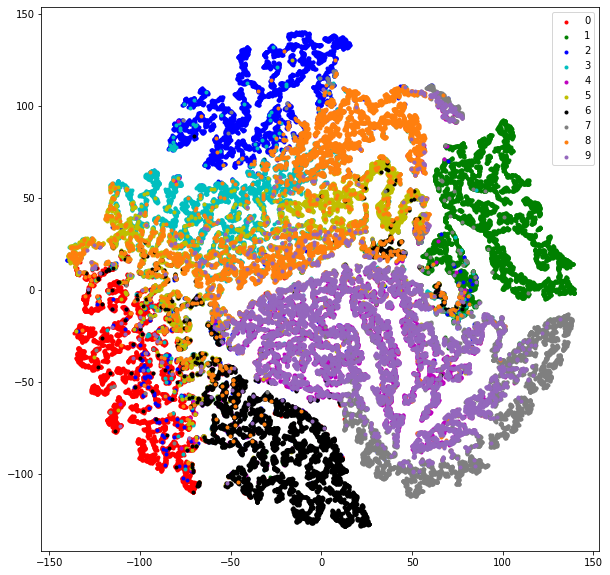

In [ ]:

from sklearn.manifold import TSNE

# 2차원 공간에 t-SNE 모델 생성
n_components=2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(z.detach().cpu().numpy())

plt.figure(figsize=(10, 10))

# label별로 다른 색으로 가시화
plt.scatter(tsne_result[whole_train_labels==0, 0], tsne_result[whole_train_labels==0, 1], marker = '.' ,c='r', label='0')
plt.scatter(tsne_result[whole_train_labels==1, 0], tsne_result[whole_train_labels==1, 1], marker = '.' ,c='g', label='1')
plt.scatter(tsne_result[whole_train_labels==2, 0], tsne_result[whole_train_labels==2, 1], marker = '.' ,c='b', label='2')
plt.scatter(tsne_result[whole_train_labels==3, 0], tsne_result[whole_train_labels==3, 1], marker = '.' ,c='c', label='3')
plt.scatter(tsne_result[whole_train_labels==4, 0], tsne_result[whole_train_labels==4, 1], marker = '.' ,c='m', label='4')
plt.scatter(tsne_result[whole_train_labels==5, 0], tsne_result[whole_train_labels==5, 1], marker = '.' ,c='y', label='5')
plt.scatter(tsne_result[whole_train_labels==6, 0], tsne_result[whole_train_labels==6, 1], marker = '.' ,c='k', label='6')
plt.scatter(tsne_result[whole_train_labels==7, 0], tsne_result[whole_train_labels==7, 1], marker = '.' ,c='tab:grey', label='7')
plt.scatter(tsne_result[whole_train_labels==8, 0], tsne_result[whole_train_labels==8, 1], marker = '.' ,c='tab:orange', label='8')
plt.scatter(tsne_result[whole_train_labels==9, 0], tsne_result[whole_train_labels==9, 1], marker = '.' ,c='tab:purple', label='9')

plt.legend()
plt.show()

## TODO: 디코더를 이용한 Generative Model 구성
1. z 공간의 임의의 위치를 sampling한 후, 이를 decoder의 입력으로 주는 방식으로 generative model을 구축한다.
2. 결과로 만들어지는 이미지는 어떤 특징을 가지고 있는지 분석한다.

# 결과 분석
z 공간의 임의의 위치를 sampling하여 이를 decoder의 입력으로 주는 generative model을 구축하였다.

결과로 만들어지는 이미지는 입력된 MNIST 데이터셋의 손글씨보다 조금 더 흐리고 부정확한 것을 볼 수 있었다.

In [42]:
## TODO
z = torch.randn(3, 2)
print(z)
z = torch.FloatTensor(z).to(device)
result = dec(z)
print(z)

print(z.shape)
print(result.shape)

tensor([[-0.6359,  0.2772],
        [ 0.3068, -0.7276],
        [-1.0599,  0.6496]])
tensor([[-0.6359,  0.2772],
        [ 0.3068, -0.7276],
        [-1.0599,  0.6496]], device='cuda:0')
torch.Size([3, 2])
torch.Size([3, 1, 28, 28])


결과 가시화

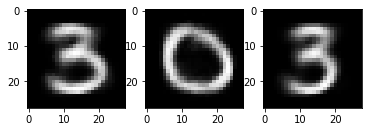

In [43]:
## TODO

# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

plt.subplot(131)
plt.imshow(to_pil_image(result[0].detach().cpu()), cmap='gray')
plt.subplot(132)
plt.imshow(to_pil_image(result[1].detach().cpu()), cmap='gray')
plt.subplot(133)
plt.imshow(to_pil_image(result[2].detach().cpu()), cmap='gray')
plt.show()


## TODO
1. 기존의 `Linear layer`를 `Conv layer`로 변경하여 결과를 확인해본다.
2. `Conv layer`로 변경 후 학습을 진행하고 평가를 진행한다.
3. 결과에 대한 분석을 작성한다.

# 결과 분석
오토인코더를 Conv layer로 변경하여 학습을 진행한 결과 Linear Layer로 학습을 진행했을 때보다 확연히 뛰어난 성능을 보여주었다.
좌측은 Linear layer 오토인코더 모델이고 우측은 Conv layer 오토인코더 모델로 진행한 결과이다.


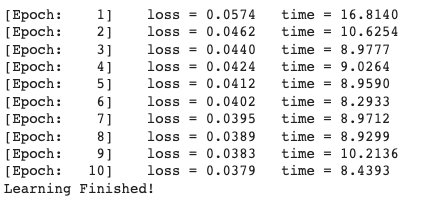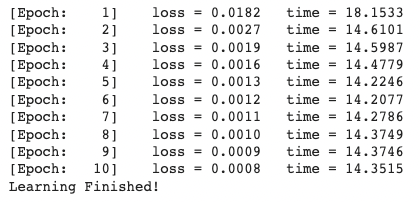

Linear layer로 구축한 오토인코더는 10번 째 epoch의 loss가 0.0379이고, Conv layer로 구축한 오토인코더는 10번 째 epoch의 loss가 0.0008으로, Conv layer로 구축한 오토인코더가 훨씬 더 적은 loss를 보여주었다.

오토인코더를 들어갔다 나온 이미지 역시 Linear layer로 구축한 오토인코더는 원본보다 좀 흐리고 부정확한 경우가 많았지만, Conv layer로 구축한 오토인코더는 원본 이미지와 거의 동일한 결과를 나타냈다.

결론적으로 이미지를 학습할 때에는 Linear layer로 오토인코더를 구축하는 것 보다 Convolution layer로 구축한 오토인코더가 더 좋은 성능을 보이는 것을 확인할 수 있었다.

In [ ]:
""" 
Convolutional AutoEncoder model 구축 
"""

## TODO
conv_enc = nn.Sequential(
  nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
  nn.ReLU(),
  nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
  nn.ReLU(),
  nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
  nn.ReLU(),
  nn.Conv2d(128, 256, kernel_size=7, stride=1),
)

conv_enc = conv_enc.to(device)
print(conv_enc)

conv_dec = nn.Sequential(
  nn.ConvTranspose2d(256, 128, kernel_size=7, stride=1),
  nn.ReLU(),
  nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
  nn.ReLU(),
  nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
  nn.ReLU(),
  nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
  nn.Sigmoid()
)

conv_dec = conv_dec.to(device)
print(conv_dec)



conv_ae = nn.Sequential(
    conv_enc,
    conv_dec,
)
conv_ae = conv_ae.to(device)
print(conv_ae)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
)
Sequential(
  (0): ConvTranspose2d(256, 128, kernel_size=(7, 7), stride=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (5): ReLU()
  (6): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): Sigmoid()
)
Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 1

In [ ]:
"""
fit 함수 작성 및 실행
"""
#파라미터 초기화와 optimizer 역시 conv_ae로 다시 진행해주어야 한다.
conv_ae.apply(init_weights)
optimizer = torch.optim.Adam(conv_ae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

## TODO
def fit(data_loader, epochs):
  for epoch in range(epochs):
    now = time.time()
    avg_loss = 0
    total_batch = len(data_loader)
    
    for i, (batch_images, batch_labels) in enumerate(data_loader):

      X = batch_images.to(device)  # [-1, 1, 28, 28]
      # print(X.shape)

      # forward 단계
      # 1. input data를 모델에 통과시킵니다.
      # 2. loss를 계산합니다.
      Y_prediction = conv_ae(X)
      loss = criterion(Y_prediction, X)

      # bacward 단계
      # 1. backprop 단계를 실행하기 전에 변화도를 0으로 만듭니다.
      # 2. 모델의 매개변수에 대한 손실의 변화도를 계산합니다.
      # 3. step 함수를 호출하면 매개변수가 갱신됩니다.
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      avg_loss += loss / total_batch

    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
          .format(epoch + 1, avg_loss.data, time.time()-now))
      
  print("Learning Finished!")


fit(train_loader, num_epochs)

[Epoch:    1] 	 loss = 0.0131 	 time = 18.9509
[Epoch:    2] 	 loss = 0.0023 	 time = 14.3599
[Epoch:    3] 	 loss = 0.0017 	 time = 14.5568
[Epoch:    4] 	 loss = 0.0013 	 time = 14.8287
[Epoch:    5] 	 loss = 0.0011 	 time = 14.4850
[Epoch:    6] 	 loss = 0.0010 	 time = 14.3319
[Epoch:    7] 	 loss = 0.0009 	 time = 14.3320
[Epoch:    8] 	 loss = 0.0008 	 time = 14.4630
[Epoch:    9] 	 loss = 0.0008 	 time = 14.4630
[Epoch:   10] 	 loss = 0.0007 	 time = 14.4968
Learning Finished!


In [ ]:
"""
학습된 Convolutional Autoencoder 통과
"""

## TODO

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx):
  (image, label) = train_dataset[idx]
  print('GT label:', label)

  X = torch.unsqueeze(image, 0).to(device) # batch size = 1 
  Y_pred = conv_ae(X)

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())

  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

In [ ]:
"""
Convolutional Autoencoder 결과 확인
"""

## TODO
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def test_dataset_imshow(idx):
  (image, label) = test_dataset[idx]
  print('GT label:', label)

  X      = torch.unsqueeze(image, 0).to(device) # batch size = 1 
  Y_pred = conv_ae(X)

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())
  
  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(test_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(test_dataset)-1, continuous_update=False))



interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=9999), Output()), _do…

<function __main__.test_dataset_imshow(idx)>